# Collaboration and Competition - Solving the Tennis Environment

---
Below we use Deep Deterministic Policy Gradient (DDPG) and Population Based Training of Neural Networks to solve a Unity-based tennis environment.

## 1. Prerequisites

To repeat the experiment in this notebook, first install the prerequisites according to the readme file. Adjust the file name of the unity environment below according to specifics of your platform.

First, we start the environment.

In [156]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [157]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. The State and Action Spaces

Let us run the code cell below to print some information about the environment, allowing us to verify that the environment matches the expectations we have outlined in the readme.

In [158]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Take Random Actions in the Environment

Before we move into training an agent based on DDPG, we can check that we know how to interact with the environment by running the code below. It uses the Python API to control the agent and receive feedback from the environment, at this point selecting entirely random actions.

In [159]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


## 4. Learning to act in the reacher environment with DDPG and Population Based Training

We will use the [Deep Deterministic Policy Gradient (DDPG) algorithm](https://arxiv.org/abs/1509.02971) (Lillicrap et al, 2016) to attempt to learn to act in the environment described in the `README.md`. The algorithm is the same as used in a previous project in the Reacher environment, but it's application to a two agent system includes additional choices.

### DDPG

The DDPG algorithm is an actor critic algorithm for updating an actor-network (an artificial neural network that implements the deterministic policy function \mu(s) - attempting to approximate the optimal policy), based on a deterministic policy gradient derived from the critic network's evaluation of the actions.

This way of using a critic that approximates the action value function Q(s,a) to provide a policy gradient for a parameterised policy was derived in the [Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) paper (Silver et al, 2014). DDPG improves the performance of the earlier algorithm by using an experience replay buffer and by using separate target networks both for the critic and the actor to stabilise learning. The target networks are continuously updated based on the live networks via a soft-update process.

The pseudocode for the whole algorithm is shown below (excerpt from [Lillicrap et al, 2016](https://arxiv.org/abs/1509.02971)).

![DDPG pseudocode, from (Lillicrap et al 2016)](DDPG-algorithm.png)

DDPG as described in the paper is a single agent reinforcement learning algorithm. Here we have a cooperative two-agent environment. We take the approach of treating each agent independently. Additionally, we use a different agent with different weights for each of the two agents playing the game, as opposed to having a single agent model play against itself. The first choice means that the environment is not stationary from the point of view of an individual agent - the learning done by the other agent changes the dynamics of the environment continuously. The fact that the other agent is a genuinely separate agent makes this issue more obvious. This has the potential of making training an agent very unstable, and methods to mitigate this have been proposed, e.g. to use a centralized critic that is aware of the actions of all agents in the environment ([Lowe et al 2018](https://arxiv.org/abs/1706.02275)). Here we instead use plain DDPG, but use it in the context of Population Based Training of Neural Networks ([Jaderberg et al, 2017](https://arxiv.org/abs/1711.09846)), hoping that using a population is enough to stabilise the training process.

### Population Based Training of Neural Networks

What remains is to define the population based training algorithm for neural networks. The approach is based on running multiple training processes in parallel, repeatedly checking how each model is performing, and making changes in the population of training processes in a way that both explores promising hyperparameter changes and allows multiple training processes to continue from earlier training results achieved by the most successful agents.

The pseudocode for the algorithm, from [Jaderberg et al, 2017](https://arxiv.org/abs/1711.09846) is shown below:

![Population Based Training](PBT-algorithm.png)

Specific choices and differences made in the implementation in this repository's implementation for a cooperative environment include:
- we run 200 training episodes for each agent separately before attempting the exploit, explore and eval steps, whereas the paper describes a more ambitious, parallel and asynchronous training procedure. Our implementation fails to get the benefits of quick training as measured in wall-clock time, but still gains the benefit of evolutionary search in model space and automatic hyperparameter search.
- we don't implement a separate eval step. The evaluation of a model's performance is simply it's average return over the 100 most recent episodes of training.
- the decision on how to exploit, i.e. replace model weights of one agent with those of another, more successful one, is done based on comparing the performance between an agent and a randomly chosen peer with the Welch's T-test. This is one of the approaches described in the original paper.
- we use the "perturb" approach to hyperparameter exploration, as described in the paper, but use a larger multiplier than the paper because we want to see the impact of population based training already in a small population and small number of episodes if possible. The perturb operation is implemented above in the `load_mutated_hyperparameters` method of the `DDPGAgent`
- each agent is paired randomly with one other agent for the 200 episodes between the exploit steps
- each agent is treated independently in the exploit step, with no regard to its pairing in the preceding training sequence.

Even though the algorithm manages to solve the environment, I suspect the last two points above are problematic, and will discuss this in the ideas for further work section below.

### Structure of the solution code

The implementation of the training algorithm is split into the following files:

`agent.py`
:  The core DDPG implementation in a `DdpgAgent` class and a `ddpg` function that uses it to implement the algorithm.

`actor.py`
:  The actor neural network

`critic.py`
:  The critic neural network

`ornstein_uhlenbeck_noise.py`
:  The noise process that is used to make the agent explore the environment in DDPG

`replaybuffer.py`
:  The replay buffer used by the DdpgAgent

`utils.py`
:  Utilities used by the other modules

`population_based_training.py`
:  The Population Based Training algorithm

`find_opponenents.py`
:  A utility that allows after the fact matching of agents based on which agent they played against during training, so that the score of the winner of each episode for each agent can be determined.

### Neural network architectures

For the actor and critic networks we use multilayer perceptrons that are similar to ones used to solve other environments in previous projects. For the actor, the important constraints are that the input dimension needs to match the state size, and the output dimension the action size. Additionally, we want the action vector components to take values between -1 and 1. We achieve this by using tanh activation on the last layer. We use the leaky relu activation function elsewhere to avoid potential problems with dead ReLUs. The original DDPG paper used L2-regularisation for the Q-network. We leave out this regularization.

Similarly, we define a suitable neural network to act as the critic network in DDPG in this environment. This time the network needs to take the combination of state and action as the input so we concatenate them. We want to allow arbitrary Q values, and therefore we don't use any nonlinearity/activation function on the output layer.

## 5. Experiment

Let us try this method on the environment. We start by importing libraries used for training and analysis.

In [1]:
import torch
import pandas
import numpy as np
import agent
import population_based_training as pbt
import matplotlib.pyplot as plt
import find_opponents
import os
%matplotlib inline


Let us define starting hyperparameters for the population of agents we are going to create. The starting hyperparameters are similar to parameters used in earlier reinforcement learning tasks in this course and seen in the papers referred to above. However, in order to understand the power of population based training, I did not spend a lot of thought on them, wanting to instead see whether population based training would lead to (eventual) success even if I didn't make optimal choices here.

In [38]:
starting_hyperparams = [{
        'actor_lr': actor_lr,
        'critic_lr': critic_lr,
        'gamma': gamma,
        'tau': tau
    }
    for actor_lr in [1e-3, 3e-4]
    for critic_lr in [1e-3, 3e-4]
    for gamma in [0.95, 0.99]
    for tau in [3e-4, 1e-4]
]
starting_hyperparams

[{'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.001, 'critic_lr': 0.0003, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.95, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.001, 'gamma': 0.99, 'tau': 0.0001},
 {'actor_lr': 0.0003, 'critic_lr': 0.0003, 'gamma': 0.95, 'tau': 0.0003},
 {'actor_lr': 0.0003, 'critic_lr': 0.0003, 'gamma': 0.

We can now create the starting population of agents based on these hyperparameters.

In [153]:
starting_agents = [
    agent.DdpgAgent(actor_lr=p['actor_lr'],
              critic_lr=p['critic_lr'],
              tau=p['tau'],
              gamma=p['gamma'],
              name="agent-{}".format(i))
    for i, p in enumerate(starting_hyperparams)]
agents = starting_agents


Now that we have defined the learning algorithm, and created the initial agent population, we are ready to proceed with the population based training approach and carry out our experiment.

In [154]:
pbt.population_based_training(agents, env, brain_name, episodes_between_exploit=200, max_episode=10000)

Paired agent-4 with agent-14
Episode 200	Average Score: -0.01
Episode 200	Average Score: -0.00

Agent: agent-4, mean return: -0.01

Agent: agent-14, mean return: -0.00
Paired agent-15 with agent-12
Episode 200	Average Score: -0.00
Episode 200	Average Score: -0.00

Agent: agent-15, mean return: -0.00

Agent: agent-12, mean return: -0.00
Paired agent-8 with agent-13
Episode 200	Average Score: -0.00
Episode 200	Average Score: -0.01

Agent: agent-8, mean return: -0.00

Agent: agent-13, mean return: -0.01
Paired agent-2 with agent-11
Episode 200	Average Score: -0.01
Episode 200	Average Score: -0.00

Agent: agent-2, mean return: -0.01

Agent: agent-11, mean return: -0.00
Paired agent-6 with agent-1
Episode 200	Average Score: -0.01
Episode 200	Average Score: -0.00

Agent: agent-6, mean return: -0.01

Agent: agent-1, mean return: -0.00
Paired agent-5 with agent-10
Episode 200	Average Score: -0.00
Episode 200	Average Score: -0.01

Agent: agent-5, mean return: -0.00

Agent: agent-10, mean return

Episode 1000	Average Score: -0.01
Episode 1000	Average Score: -0.00

Agent: agent-5, mean return: -0.01

Agent: agent-15, mean return: -0.00
Paired agent-2 with agent-8
Episode 1000	Average Score: -0.01
Episode 1000	Average Score: -0.00

Agent: agent-2, mean return: -0.01

Agent: agent-8, mean return: -0.00
Paired agent-14 with agent-6
Episode 1000	Average Score: 0.01
Episode 1000	Average Score: -0.01

Agent: agent-14, mean return: 0.01

Agent: agent-6, mean return: -0.01
agent-0 performed worse than agent-4 but it wasn't significant, p = 0.50
agent-1 performed worse than agent-7 but it wasn't significant, p = 0.06
agent-5 performed worse than agent-15 but it wasn't significant, p = 0.11
Overwriting agent-6 with agent-7, p = 0.00
agent-10 performed worse than agent-7 but it wasn't significant, p = 0.11
agent-11 performed worse than agent-8 but it wasn't significant, p = 0.19
Overwriting agent-12 with agent-14, p = 0.00
agent-13 performed worse than agent-4 but it wasn't significant, p 

agent-11 performed worse than agent-15 but it wasn't significant, p = 0.51
Overwriting agent-13 with agent-0, p = 0.00
Overwriting agent-14 with agent-0, p = 0.00
Overwriting agent-15 with agent-3, p = 0.00
Paired agent-10 with agent-3
Episode 2000	Average Score: -0.00
Episode 2000	Average Score: 0.02

Agent: agent-10, mean return: -0.00

Agent: agent-3, mean return: 0.02
Paired agent-5 with agent-9
Episode 2000	Average Score: 0.03
Episode 2000	Average Score: -0.01

Agent: agent-5, mean return: 0.03

Agent: agent-9, mean return: -0.01
Paired agent-6 with agent-14
Episode 2000	Average Score: 0.03
Episode 2000	Average Score: 0.01

Agent: agent-6, mean return: 0.03

Agent: agent-14, mean return: 0.01
Paired agent-15 with agent-4
Episode 2000	Average Score: 0.02
Episode 2000	Average Score: -0.01

Agent: agent-15, mean return: 0.02

Agent: agent-4, mean return: -0.01
Paired agent-1 with agent-11
Episode 2000	Average Score: -0.00
Episode 2000	Average Score: -0.01

Agent: agent-1, mean return

Overwriting agent-5 with agent-13, p = 0.00
Overwriting agent-6 with agent-7, p = 0.01
Overwriting agent-8 with agent-15, p = 0.00
Overwriting agent-9 with agent-1, p = 0.00
Overwriting agent-10 with agent-0, p = 0.00
Overwriting agent-12 with agent-3, p = 0.00
Overwriting agent-14 with agent-3, p = 0.00
Paired agent-0 with agent-3
Episode 3000	Average Score: 0.17
Episode 3000	Average Score: 0.18

Agent: agent-0, mean return: 0.17

Agent: agent-3, mean return: 0.18
Paired agent-7 with agent-1
Episode 3000	Average Score: 0.08
Episode 3000	Average Score: 0.07

Agent: agent-7, mean return: 0.08

Agent: agent-1, mean return: 0.07
Paired agent-2 with agent-14
Episode 3000	Average Score: 0.15
Episode 3000	Average Score: 0.15

Agent: agent-2, mean return: 0.15

Agent: agent-14, mean return: 0.15
Paired agent-5 with agent-6
Episode 3000	Average Score: 0.06
Episode 3000	Average Score: 0.06

Agent: agent-5, mean return: 0.06

Agent: agent-6, mean return: 0.06
Paired agent-11 with agent-8
Episode


Agent: agent-13, mean return: 0.27

Agent: agent-15, mean return: 0.27
Paired agent-12 with agent-4
Episode 3800	Average Score: 0.53
Episode 3800	Average Score: 0.53

Agent: agent-12, mean return: 0.53

Agent: agent-4, mean return: 0.53
Paired agent-10 with agent-8
Episode 3800	Average Score: 0.27
Episode 3800	Average Score: 0.26

Agent: agent-10, mean return: 0.27

Agent: agent-8, mean return: 0.26
Paired agent-14 with agent-6
Episode 3800	Average Score: 0.42
Episode 3800	Average Score: 0.41

Agent: agent-14, mean return: 0.42

Agent: agent-6, mean return: 0.41
Overwriting agent-3 with agent-12, p = 0.00
Overwriting agent-8 with agent-12, p = 0.00
Overwriting agent-10 with agent-14, p = 0.00
agent-11 performed worse than agent-4 but it wasn't significant, p = 0.22
Overwriting agent-13 with agent-5, p = 0.00
agent-14 performed worse than agent-2 but it wasn't significant, p = 0.25
Overwriting agent-15 with agent-7, p = 0.02
Paired agent-2 with agent-14
Episode 4000	Average Score: 0.43

Episode 4800	Average Score: 0.32
Episode 4800	Average Score: 0.34

Agent: agent-11, mean return: 0.32

Agent: agent-4, mean return: 0.34
Paired agent-0 with agent-15
Episode 4800	Average Score: 0.30
Episode 4800	Average Score: 0.31

Agent: agent-0, mean return: 0.30

Agent: agent-15, mean return: 0.31
Paired agent-14 with agent-8
Episode 4800	Average Score: 0.55
Episode 4800	Average Score: 0.53

Agent: agent-14, mean return: 0.55

Agent: agent-8, mean return: 0.53
Paired agent-6 with agent-13
Episode 4800	Average Score: 0.53
Episode 4800	Average Score: 0.52

Agent: agent-6, mean return: 0.53

Agent: agent-13, mean return: 0.52
Paired agent-1 with agent-10
Episode 4800	Average Score: 0.51
Episode 4800	Average Score: 0.52

Agent: agent-1, mean return: 0.51

Agent: agent-10, mean return: 0.52
Paired agent-12 with agent-2
Episode 4800	Average Score: 0.62
Episode 4800	Average Score: 0.59

Agent: agent-12, mean return: 0.62

Agent: agent-2, mean return: 0.59
Paired agent-9 with agent-3
Episo

Episode 5600	Average Score: 0.87
Episode 5600	Average Score: 0.86

Agent: agent-8, mean return: 0.87

Agent: agent-1, mean return: 0.86
Overwriting agent-0 with agent-8, p = 0.00
Overwriting agent-5 with agent-13, p = 0.01
agent-6 performed worse than agent-7 but it wasn't significant, p = 0.91
Overwriting agent-7 with agent-8, p = 0.00
Overwriting agent-9 with agent-10, p = 0.00
Overwriting agent-11 with agent-10, p = 0.01
agent-14 performed worse than agent-4 but it wasn't significant, p = 0.64
agent-15 performed worse than agent-11 but it wasn't significant, p = 0.29
Paired agent-11 with agent-3
Episode 5800	Average Score: 0.40
Episode 5800	Average Score: 0.42

Agent: agent-11, mean return: 0.40

Agent: agent-3, mean return: 0.42
Paired agent-7 with agent-12
Episode 5800	Average Score: 0.53
Episode 5800	Average Score: 0.53

Agent: agent-7, mean return: 0.53

Agent: agent-12, mean return: 0.53
Paired agent-10 with agent-5
Episode 5800	Average Score: 0.51
Episode 5800	Average Score: 0

Episode 6600	Average Score: 0.33
Episode 6600	Average Score: 0.31

Agent: agent-1, mean return: 0.33

Agent: agent-12, mean return: 0.31
Paired agent-10 with agent-8
Episode 6600	Average Score: 0.24
Episode 6600	Average Score: 0.23

Agent: agent-10, mean return: 0.24

Agent: agent-8, mean return: 0.23
Overwriting agent-0 with agent-15, p = 0.00
Overwriting agent-1 with agent-4, p = 0.00
Overwriting agent-6 with agent-1, p = 0.00
Overwriting agent-9 with agent-8, p = 0.00
Overwriting agent-10 with agent-12, p = 0.04
agent-12 performed worse than agent-13 but it wasn't significant, p = 0.30
Overwriting agent-13 with agent-11, p = 0.00
Paired agent-12 with agent-1
Episode 6800	Average Score: 0.48
Episode 6800	Average Score: 0.49

Agent: agent-12, mean return: 0.48

Agent: agent-1, mean return: 0.49
Paired agent-14 with agent-0
Episode 6800	Average Score: 0.27
Episode 6800	Average Score: 0.27

Agent: agent-14, mean return: 0.27

Agent: agent-0, mean return: 0.27
Paired agent-2 with agent-1

Episode 7600	Average Score: 0.49
Episode 7600	Average Score: 0.48

Agent: agent-6, mean return: 0.49

Agent: agent-1, mean return: 0.48
Paired agent-9 with agent-2
Episode 7600	Average Score: 0.52
Episode 7600	Average Score: 0.51

Agent: agent-9, mean return: 0.52

Agent: agent-2, mean return: 0.51
Paired agent-4 with agent-0
Episode 7600	Average Score: 0.51
Episode 7600	Average Score: 0.50

Agent: agent-4, mean return: 0.51

Agent: agent-0, mean return: 0.50
Paired agent-11 with agent-5
Episode 7600	Average Score: 0.53
Episode 7600	Average Score: 0.53

Agent: agent-11, mean return: 0.53

Agent: agent-5, mean return: 0.53
Paired agent-8 with agent-12
Episode 7600	Average Score: 0.43
Episode 7600	Average Score: 0.43

Agent: agent-8, mean return: 0.43

Agent: agent-12, mean return: 0.43
Paired agent-3 with agent-14
Episode 7600	Average Score: 0.31
Episode 7600	Average Score: 0.31

Agent: agent-3, mean return: 0.31

Agent: agent-14, mean return: 0.31
Paired agent-10 with agent-13
Episode 

Episode 8400	Average Score: 0.44

Agent: agent-3, mean return: 0.43

Agent: agent-10, mean return: 0.44
agent-0 performed worse than agent-10 but it wasn't significant, p = 0.40
agent-2 performed worse than agent-4 but it wasn't significant, p = 0.44
agent-3 performed worse than agent-2 but it wasn't significant, p = 0.50
agent-5 performed worse than agent-9 but it wasn't significant, p = 0.08
agent-7 performed worse than agent-3 but it wasn't significant, p = 0.72
agent-10 performed worse than agent-8 but it wasn't significant, p = 0.13
Overwriting agent-13 with agent-11, p = 0.00
agent-14 performed worse than agent-10 but it wasn't significant, p = 0.46
Paired agent-11 with agent-12
Episode 8600	Average Score: 0.75
Episode 8600	Average Score: 0.76

Agent: agent-11, mean return: 0.75

Agent: agent-12, mean return: 0.76
Paired agent-13 with agent-2
Episode 8600	Average Score: 0.55
Episode 8600	Average Score: 0.55

Agent: agent-13, mean return: 0.55

Agent: agent-2, mean return: 0.55
Pa


Agent: agent-6, mean return: 0.51

Agent: agent-12, mean return: 0.52
Paired agent-4 with agent-7
Episode 9400	Average Score: 0.57
Episode 9400	Average Score: 0.56

Agent: agent-4, mean return: 0.57

Agent: agent-7, mean return: 0.56
Paired agent-5 with agent-8
Episode 9400	Average Score: 0.61
Episode 9400	Average Score: 0.59

Agent: agent-5, mean return: 0.61

Agent: agent-8, mean return: 0.59
Paired agent-15 with agent-11
Episode 9400	Average Score: 0.50
Episode 9400	Average Score: 0.50

Agent: agent-15, mean return: 0.50

Agent: agent-11, mean return: 0.50
agent-0 performed worse than agent-3 but it wasn't significant, p = 0.92
agent-1 performed worse than agent-0 but it wasn't significant, p = 0.34
agent-2 performed worse than agent-9 but it wasn't significant, p = 0.24
agent-11 performed worse than agent-5 but it wasn't significant, p = 0.08
agent-12 performed worse than agent-4 but it wasn't significant, p = 0.39
agent-15 performed worse than agent-9 but it wasn't significant, p

## 6. Analysis

The training run takes a long time, especially as the agents learn to keep the ball in the air, leading to episodes running to the maximum duration instead of ending early when the agents lose control over the ball.

Because our implementation of DDPG and PBT save the state of the agents and their histories on disk at every exploit step, we are able to analyse results already while the long training run is still running in a different notebook window, or even on a different computer. To continue analysis from saved files, I combined only the essential history information into one file for analysis. I did this work in a separate notebook [Bundle_histories.ipynb](Bundle_histories.ipynb). The code in that notebook saves the history to [population_history.pt](population_history.pt). Below we load the history from that file and continue our analysis to find out if and after how many episodes the environment was solved.

In [16]:
training_results = torch.load(os.path.join('models', 'pbt_run_1', 'population_history.pt'))
for agent_history in training_results['histories']:
    agent_history.set_index('episode', inplace=True)

Let us plot the raw, agent by agent training results in terms of undiscounted returns.

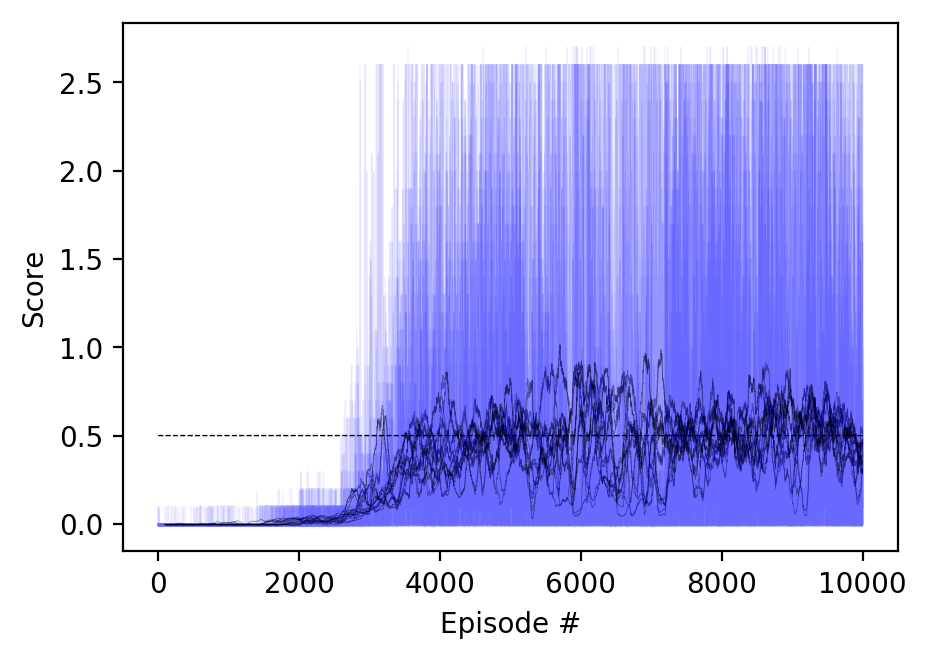

In [162]:
fig = plt.figure(figsize=(5,3.5), dpi=200)
for agent_history in training_results['histories']:
    plt.plot(agent_history.index, agent_history['return'], alpha=0.05, color='blue', linewidth=0.5)
    plt.plot(agent_history.index, agent_history.rolling(100).mean()['return'], alpha=0.4, color='black', linewidth=0.25)
plt.plot(training_results['histories'][0].index, np.ones(len(training_results['histories'][0])) * 0.5, alpha=1, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

**Fig 1. Raw training results.** Blue shows the episode by episode returns for each agent. Black shows 100 episode averages for each agent. Dashed black line shows the performance level where the environment is considered solved.

Unfortunately, we haven't directly saved the information required to determine when the environment was solved according to the project instructions. These make the maximum return of either agent the quantity that should be compared to 0.5, whereas we have only stored individual agent's returns. Fortunately, the output of our training run, which we now copy to `training_log.txt` contains enough information to determine which agent played against which for each episode, and therefore allows us to reconstruct the score of the "winner" of each episode for each agent. The cells below do just that, and add the result into a new column on the history dataframes.

In [18]:
opponent_finder = find_opponents.OpponentFinder(os.path.join('models', 'pbt_run_1', "training_log.txt"))

In [19]:
for agent, history in enumerate(training_results['histories']):
    for episode in history.index:
        history.loc[episode, 'winner_return'] = max(
            history.loc[episode, 'return'],
            training_results['histories'][opponent_finder.find_opponent(agent, episode)].loc[episode, 'return'])

Equipped with the right dataset, let us find out when the first agent solved the environmet.

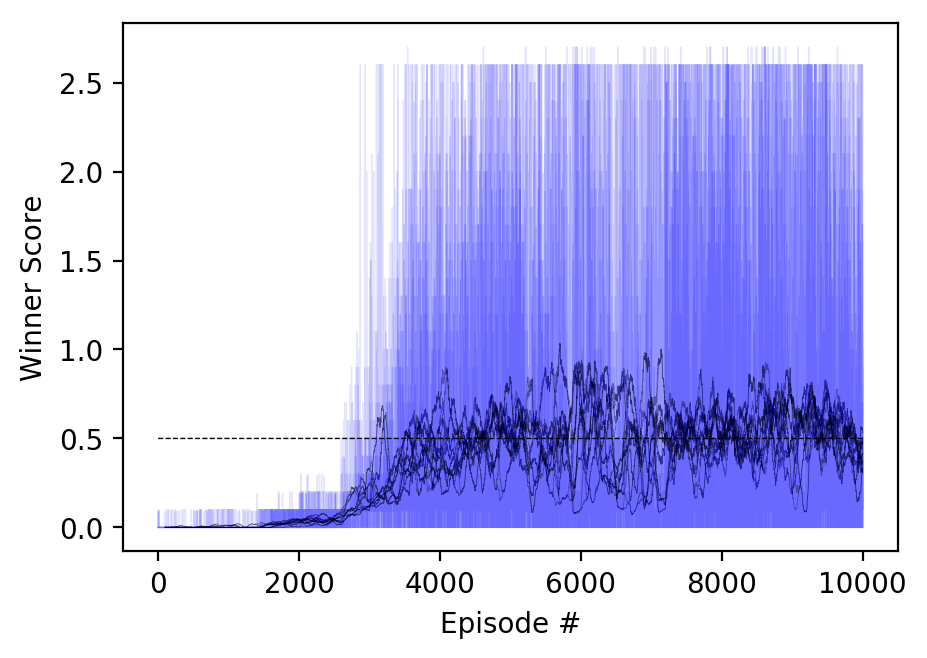

In [168]:
fig = plt.figure(figsize=(5,3.5), dpi=200)
for agent_history in training_results['histories']:
    plt.plot(agent_history.index, agent_history['winner_return'], alpha=0.05, color='blue', linewidth=0.5)
    plt.plot(agent_history.index, agent_history.rolling(100).mean()['winner_return'], alpha=0.4, color='black', linewidth=0.25)
plt.plot(training_results['histories'][0].index, np.ones(len(training_results['histories'][0])) * 0.5, alpha=1, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Winner Score')
plt.xlabel('Episode #')
plt.show()

**Fig. 2. Winner score by episode.** Same as figure 1. but using the maximim of the agent's score and the opposing agent's score.

Let us determine which agent first reaches the threshold 0.5 indicating it has solved the environment.

In [169]:
first_to_solve = None
first_solved_episode = None
for agent, history in enumerate(training_results['histories']):
    means = history.rolling(100).mean()['winner_return']
    solved_episode = means[means > 0.5].index[0]
    print((agent, solved_episode))
    if first_to_solve is None or solved_episode < first_solved_episode:
        first_to_solve = agent
        first_solved_episode = solved_episode
print("Agent {} solved the environment after {} episodes".format(first_to_solve, first_solved_episode - 100))

(0, 3641)
(1, 3804)
(2, 3655)
(3, 3099)
(4, 3099)
(5, 3179)
(6, 3179)
(7, 3499)
(8, 3866)
(9, 3974)
(10, 4384)
(11, 3652)
(12, 3492)
(13, 3493)
(14, 3630)
(15, 3873)
Agent 3 solved the environment after 2999 episodes


We find out the first agent to solve the environment is **agent 3 which solved the environment after 2999 episodes**. Below we also show the episodes at which a model of agent-3 was retired, verifying that this did not occur during the window used for priving that the environment was solved.

In [170]:
[(agent, episode) for (agent, episode) in training_results['retirements'] if agent == 3]

[(3, 800),
 (3, 3400),
 (3, 3800),
 (3, 4800),
 (3, 5400),
 (3, 7000),
 (3, 7200),
 (3, 8000),
 (3, 9000)]

Let us similarly find out if and when the population average reaches 0.5 during training.

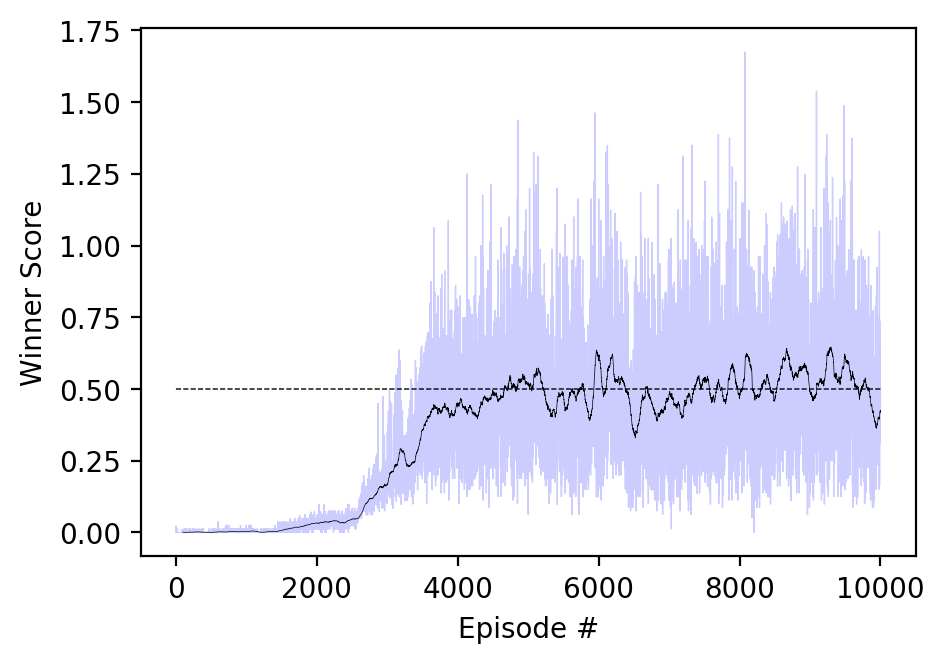

In [171]:
all_agent_results = pandas.concat(training_results['histories']) 
mean_over_agents = all_agent_results.groupby(all_agent_results.index).mean()

fig = plt.figure(figsize=(5,3.5), dpi=200)
plt.plot(mean_over_agents.index, mean_over_agents['winner_return'], alpha=0.2, color='blue', linewidth=0.5)
plt.plot(mean_over_agents.index, mean_over_agents.rolling(100).mean()['winner_return'], alpha=1, color='black', linewidth=0.25)
plt.plot(training_results['histories'][0].index, np.ones(len(training_results['histories'][0])) * 0.5, alpha=1, color='black', linewidth=0.5, linestyle='--')
plt.ylabel('Winner Score')
plt.xlabel('Episode #')
plt.show()

**Fig. 3. Population average performance.** Blue indicates averages over agents during individual episodes, black is the 100 episode average, which shows that the population did reach a level where on average all agents solve the environment.

Let us find when exactly this happens.

In [172]:
population_means = mean_over_agents.rolling(100).mean()['winner_return']
population_means[population_means > 0.5].head(1)

episode
4661    0.5006
Name: winner_return, dtype: float64

**The average of every agent reaches the solved environment threshold of 0.5 after 4561 episodes.**

After the training run, we can close the environment.

In [173]:
env.close()

## 7. Observing a pre-trained agent

If you want to simply observe a pair of pre-trained agents, the following code can be used to do that. We assume there is no Unity environment open when this code is run. The weights saved below are from the first agent that reached the 0.5 score average, and from a later agent that showed particularly high performance.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
agent1 = agent.DdpgAgent()
agent2 = agent.DdpgAgent()
agent1.load_full_save_dict(torch.load('agent-13_episode_5800.pth'))
agent2.load_full_save_dict(torch.load('agent-3_episode_3000.pth'))
num_agents = 2

for episode in range(5):
    env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    time = 0
    while True:
        action1 = agent1.act(states[0], noise=False) # select an action
        action2 = agent2.act(states[1], noise=False) # select an action
        env_info = env.step(np.vstack((action1, action2)))[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        time += 1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
    print(time)


C:\Users\mikko\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Total score (averaged over agents) this episode: 0.19500000309199095
103
Total score (averaged over agents) this episode: 1.095000016503036
431


In [123]:
env.close()

## 8. Ideas for further Work

Population based training together with DDPG seems to solve the environment in a fairly robust way. However, there are still moments when the performance of the population drops quickly late in the training, and during the early episodes, the learning results appear slow.

The most pressing experiment to carry out would be to test the hypothesis that poorly chosen details of the how the population based training is applied to the two agent cooperative scenario. In the current setup, it is possible for a successful agent to be paired with a poor quality agent and be overwritten. In a cooperative task the higher quality agent alone cannot reach high performance. The experiment that seems the most promising would be to ensure each agent faces each other agent between the exploit steps of PBT.

The second issue may be a result of the agents overfitting into a limited sample of experience early on in the training process. Additional experiments could be carried out to examine if the early learning performance is better after mitigating this either by:
- adding regularization (e.g. Dropout or L2) to the networks (the original paper uses L2 for the critic), or
- implementing a grace period where the agent first collects a sample of experience that is significantly larger than one minibatch before carrying out any training.

In this work I use the same noise process with the same parameters throughout the training. It may be more appropriate to explore more early on (more noise) and act closer to the learned approximation of optimal policy later on (less noise). It would be interesting to experiment on both a fixed noise reduction schedule, and treating the noise parameters as hyperparameters explored by the population based training procedure.

Additional changes that may improve agent performance would include experimenting with different network architectures. The networks currently used by the actor and the critic are small compared to e.g. the DDPG paper's networks.

Additionally, it would be interesting to examine the changes made to hyperparameters during the population based training process.
